# Logistic Regression: Banking Marketing Campaign

## 1. Data loading

In [1]:
# Handle imports upfront
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### 1.1. Load

In [2]:
data_url='https://raw.githubusercontent.com/4GeeksAcademy/logistic-regression-project-tutorial/main/bank-marketing-campaign-data.csv'
data_df=pd.read_csv(data_url, sep=';')

### 1.2. Inspect

In [3]:
data_df.head().transpose()

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### 1.3. Train-test split

In [5]:
# Do the test-train split
training_df, testing_df=train_test_split(
    data_df,
    test_size=0.25
)

## 2. EDA

### 2.1. Baseline model performance

In [6]:
# How many yes/no labels do we have
training_df['y'].value_counts()

y
no     27403
yes     3488
Name: count, dtype: int64

In [7]:
# Accuracy for constant 'no' model
accuracy=(training_df['y'].value_counts()['no']/len(training_df['y']))*100
print(f'Accuracy of constant "no" model: {accuracy:.1f}%')

Accuracy of constant "no" model: 88.7%


### 2.2. Data composition & cleaning

#### 2.2.1. Categorical features

In [8]:
categorical_features=['y','job','education','marital','default','housing','loan','contact','poutcome','day_of_week','month']

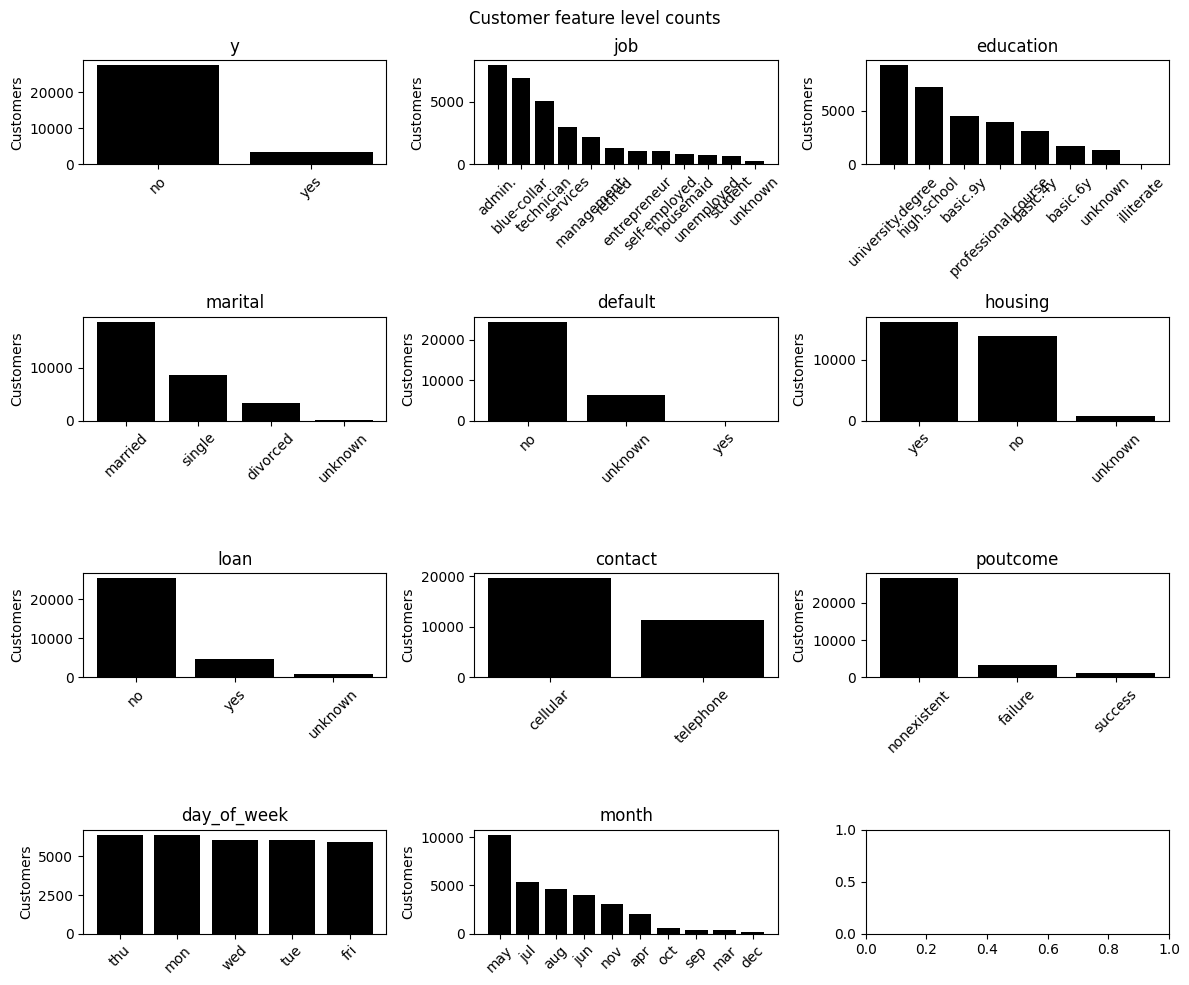

In [9]:
fig, axs=plt.subplots(4,3, figsize=(12,10))
axs=axs.flatten()

fig.suptitle('Customer feature level counts')

for i, feature in enumerate(categorical_features):

    # Plot neighborhood group level counts
    level_counts=training_df[feature].value_counts()

    axs[i].set_title(feature)
    axs[i].bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color='black')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_ylabel('Customers')

fig.tight_layout()
fig.show()

#### 2.2.2. Numerical features

In [10]:
numerical_features=['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

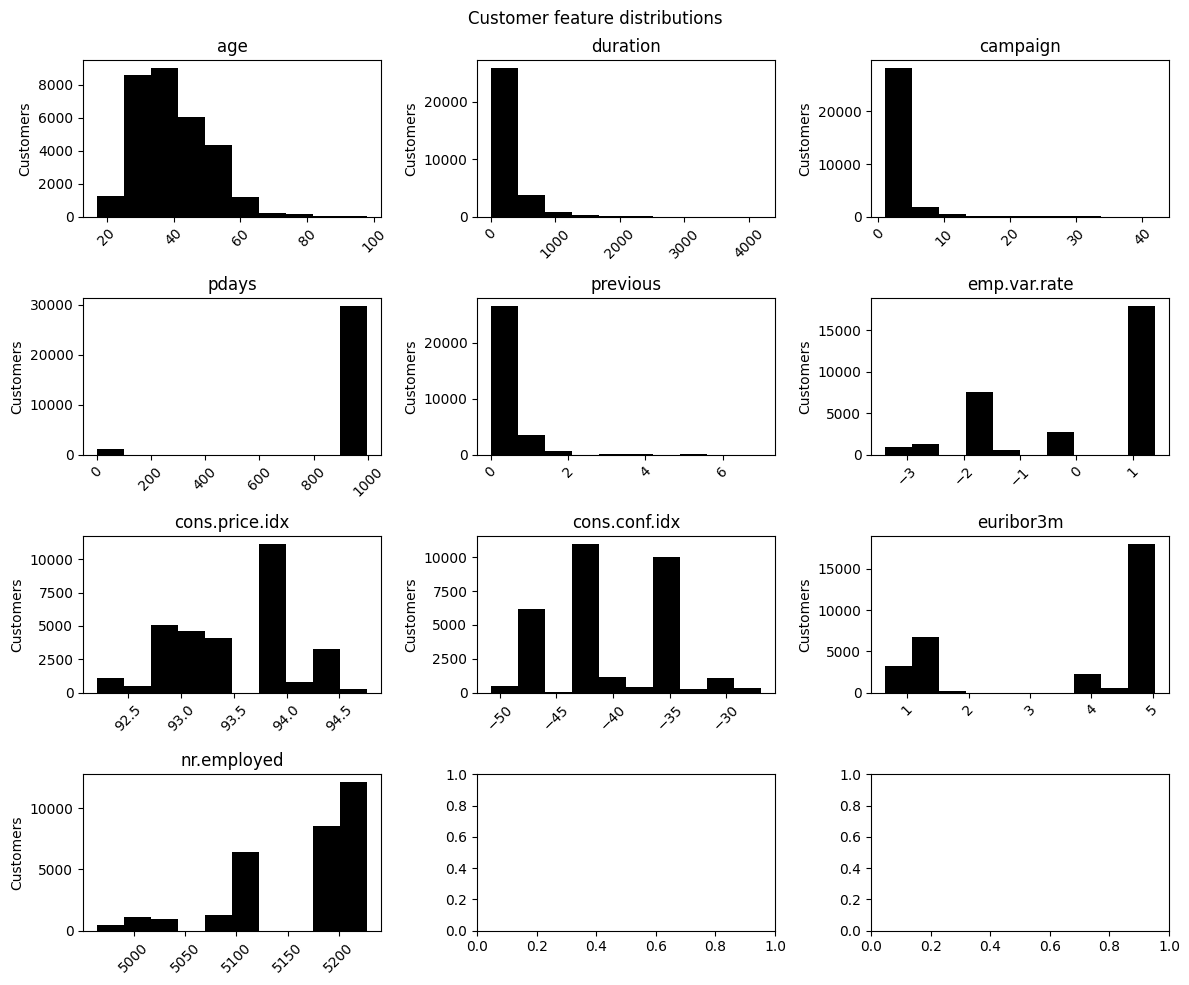

In [11]:
fig, axs=plt.subplots(4,3, figsize=(12,10))
axs=axs.flatten()

fig.suptitle('Customer feature distributions')

for i, feature in enumerate(numerical_features):

    axs[i].set_title(feature)
    axs[i].hist(training_df[feature], color='black')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_ylabel('Customers')

fig.tight_layout()
fig.show()

### 2.3. Feature interactions & selection

#### 2.3.1. Categorical features vs label

In [12]:
categorical_features=['job','marital','default','housing','loan','contact','poutcome','day_of_week','month']

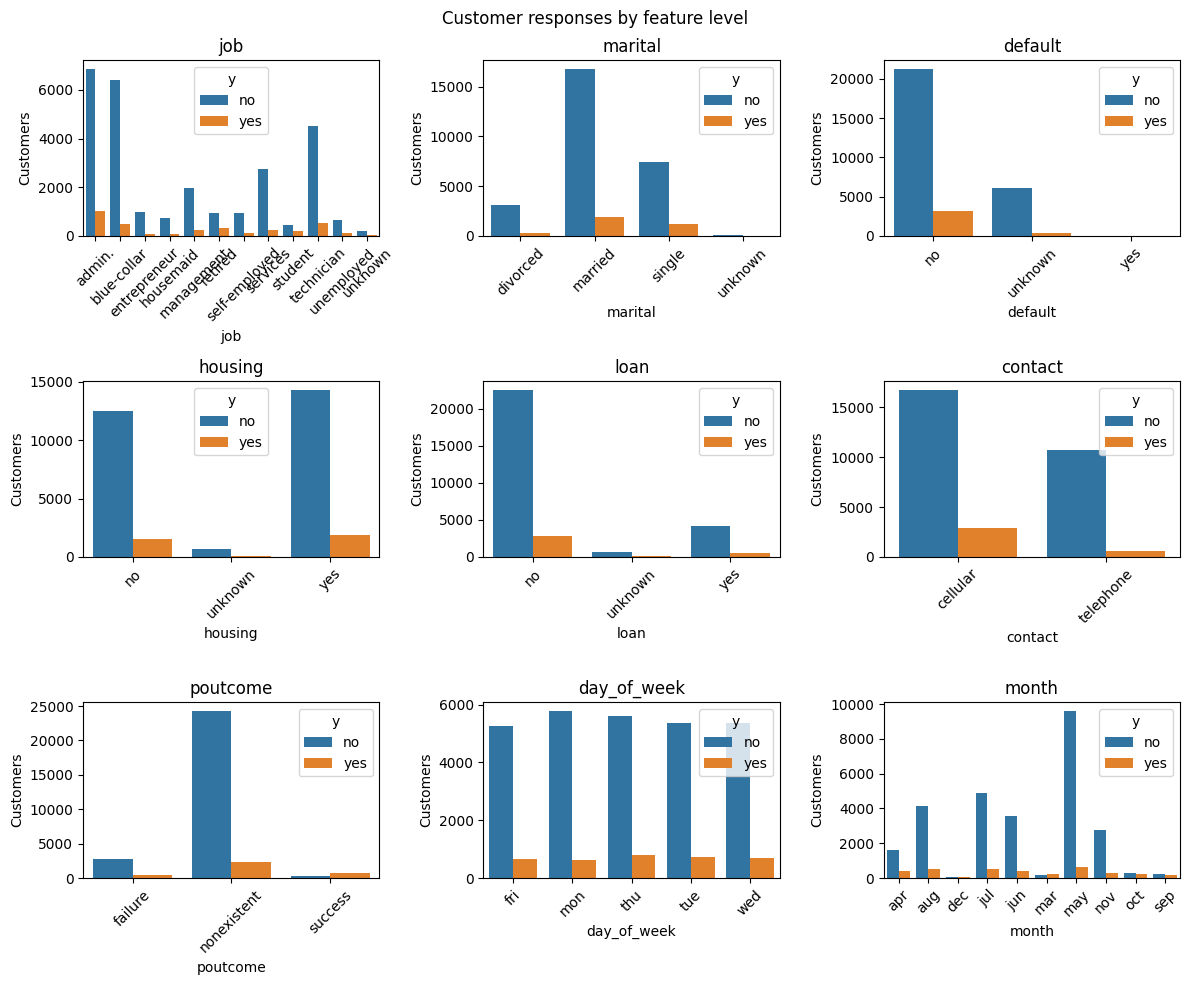

In [13]:
fig, axs=plt.subplots(3,3, figsize=(12,10))
axs=axs.flatten()

fig.suptitle('Customer responses by feature level')

for i, feature in enumerate(categorical_features):
    groups=training_df.groupby([feature, 'y']).size()
    groups_df=groups.reset_index()
    groups_df.rename({0: 'Customers'}, axis=1, inplace=True)

    axs[i].set_title(f'{feature}')
    sns.barplot(groups_df, x=feature, y='Customers', hue='y', ax=axs[i])
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_ylabel('Customers')

fig.tight_layout()
fig.show()

#### 2.3.2. Numerical features vs label

In [14]:
numerical_features=['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

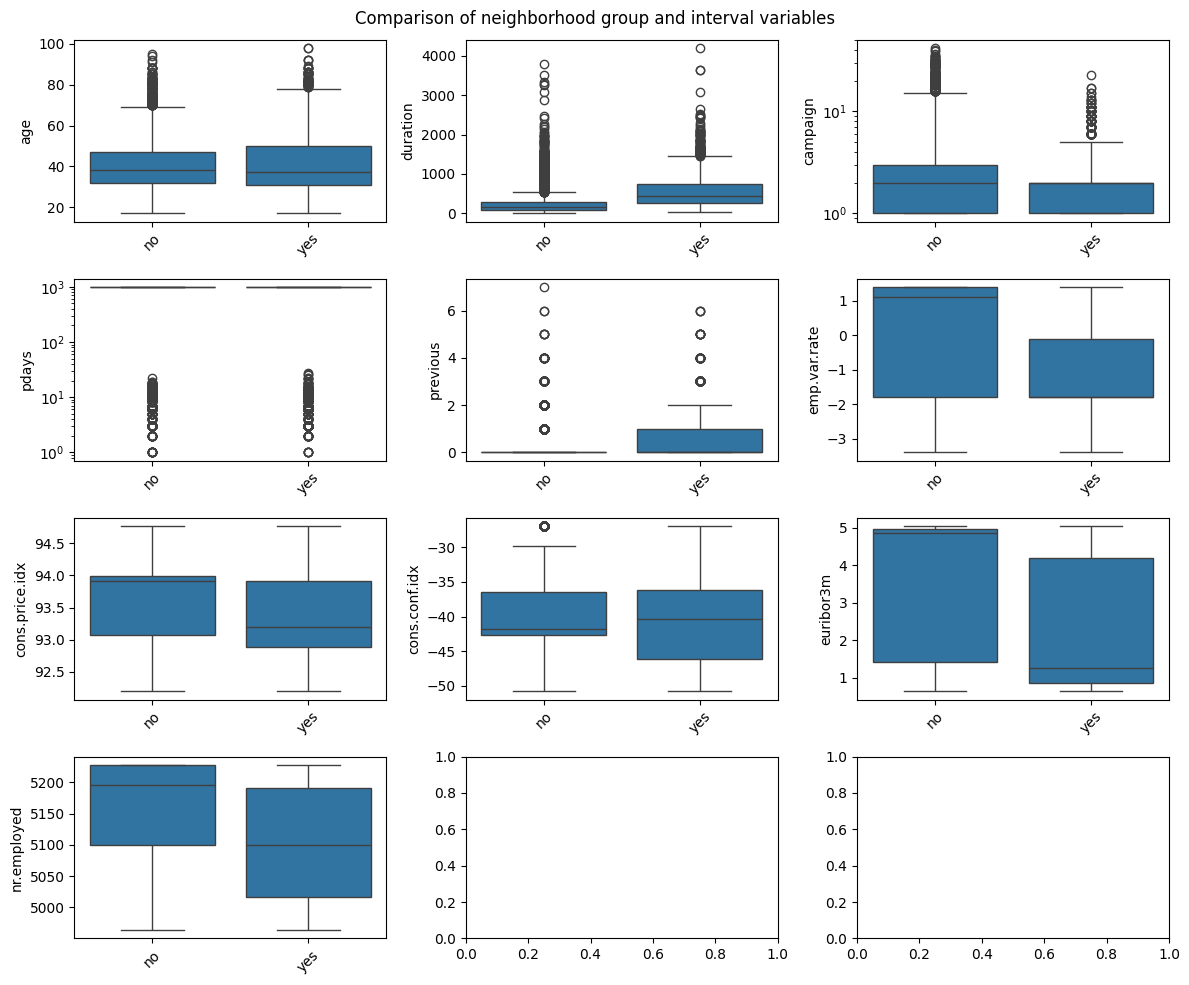

In [15]:
fig, axs=plt.subplots(4,3, figsize=(12,10))
axs=axs.flatten()

fig.suptitle('Comparison of neighborhood group and interval variables')

for i, feature in enumerate(numerical_features):

    plot_df=training_df[training_df[feature] != 0]

    if stats.kurtosis(plot_df[feature].dropna()) > 20:
        log_scale=True
    else:
        log_scale=False

    sns.boxplot(training_df, x='y', y=feature, log_scale=log_scale, ax=axs[i])
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel('')
    axs[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

#### 2.3.3. Feature drops

In [16]:
feature_drops=['pdays']
training_df.drop(feature_drops, axis=1, inplace=True)
testing_df.drop(feature_drops, axis=1, inplace=True)

### 2.4. Feature encoding & scaling

#### 2.4.1. Categorical feature encoding

In [17]:
categorical_features=['job','marital','default','housing','loan','contact','poutcome']

encoder=OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(training_df[categorical_features])
encoded_training_features=encoder.transform(training_df[categorical_features])
encoded_testing_features=encoder.transform(testing_df[categorical_features])

encoded_training_features_df=pd.DataFrame(
    encoded_training_features,
    columns=encoder.get_feature_names_out()
)

encoded_testing_features_df=pd.DataFrame(
    encoded_testing_features,
    columns=encoder.get_feature_names_out()
)

encoded_training_features_df.head().transpose()

,0,1,2,3,4
job_blue-collar,0.0,0.0,0.0,0.0,0.0
job_entrepreneur,0.0,0.0,0.0,0.0,0.0
job_housemaid,0.0,0.0,0.0,0.0,0.0
job_management,1.0,0.0,0.0,0.0,0.0
job_retired,0.0,0.0,0.0,0.0,0.0
job_self-employed,0.0,0.0,0.0,0.0,0.0
job_services,0.0,0.0,1.0,0.0,0.0
job_student,0.0,0.0,0.0,0.0,0.0
job_technician,0.0,0.0,0.0,0.0,1.0
job_unemployed,0.0,0.0,0.0,0.0,0.0


you could replace the original categorical features with their encoded versions now like this:

In [ ]:
# training_df.drop(categorical_features, inplace=True, axis=1)
# training_df=pd.concat([training_df.reset_index(drop=True), encoded_training_features_df.reset_index(drop=True)], axis=1)

#### 2.4.2. Numerical feature scaling

In [20]:
numerical_features=['age','duration','campaign','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

standard_scaler=StandardScaler().fit(training_df[numerical_features])
scaled_training_features=standard_scaler.transform(training_df[numerical_features])
scaled_testing_features=standard_scaler.transform(testing_df[numerical_features])

scaled_training_features_df=pd.DataFrame(
    scaled_training_features,
    columns=numerical_features
)

scaled_testing_features_df=pd.DataFrame(
    scaled_testing_features,
    columns=numerical_features
)

scaled_training_features_df.describe()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,3.089100e+04,3.089100e+04,3.089100e+04,3.089100e+04,3.089100e+04,3.089100e+04,3.089100e+04,3.089100e+04,3.089100e+04
mean,-6.325443e-18,-1.840129e-17,-8.326583e-17,-2.944206e-17,6.900483e-18,-2.069363e-14,6.587661e-16,-6.946486e-17,-8.162351e-15
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-2.209742e+00,-1.007658e+00,-5.766112e-01,-3.495965e-01,-2.214074e+00,-2.374219e+00,-2.221736e+00,-1.717767e+00,-2.808802e+00
25%,-7.678976e-01,-6.047911e-01,-5.766112e-01,-3.495965e-01,-1.195760e+00,-8.645223e-01,-4.714259e-01,-1.308849e+00,-9.365042e-01
50%,-1.911599e-01,-3.036191e-01,-2.078536e-01,-3.495965e-01,6.499353e-01,2.997061e-01,-2.769470e-01,7.144304e-01,3.333420e-01
75%,6.739466e-01,2.400550e-01,1.609039e-01,-3.495965e-01,8.408692e-01,7.229049e-01,8.899263e-01,7.743282e-01,8.459786e-01
max,5.576217e+00,1.541600e+01,1.454245e+01,1.383878e+01,8.408692e-01,2.058140e+00,2.942759e+00,8.227072e-01,8.459786e-01


#### 2.4.3. Time feature encoding

In [21]:
def encode_time_features(data_df: pd.DataFrame) -> pd.DataFrame:
    '''Takes a Pandas dataframe and uses cyclical sin/cos to encode
    month and day features. Returns updated dataframe.'''

    time_df=data_df.copy()

    # First convert the features to numeric
    dict={'mon' : '1', 'tue' : '2', 'wed': '3', 'thu' : '4', 'fri': '5'}
    time_df['day_of_week']=time_df['day_of_week'].replace(dict)

    dict={'jan' : '1', 'feb' : '2', 'mar': '3', 'apr' : '4', 'may': '5', 'jun': '6', 'jul': '7', 'aug': '8', 'sep': '9', 'oct': '10', 'nov': '11', 'dec': '12'}
    time_df['month']=time_df['month'].replace(dict)

    # And fix the dtypes
    time_df['day_of_week']=time_df['day_of_week'].astype(float)
    time_df['month']=time_df['month'].astype(float)

    # Now encode the day and month with sin/cos components
    time_df['day_sin']=np.sin(2 * np.pi * time_df['day_of_week']/7.0)
    time_df['day_cos']=np.cos(2 * np.pi * time_df['day_of_week']/7.0)

    time_df['month_sin']=np.sin(2 * np.pi * time_df['month']/12.0)
    time_df['month_cos']=np.cos(2 * np.pi * time_df['month']/12.0)

    # Drop the original string features
    time_df.drop(['month', 'day_of_week'], axis=1, inplace=True)

    return time_df.reset_index(drop=True)

training_time_features=encode_time_features(training_df[['day_of_week', 'month']])
testing_time_features=encode_time_features(testing_df[['day_of_week', 'month']])

training_time_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30891 entries, 0 to 30890
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   day_sin    30891 non-null  float64
 1   day_cos    30891 non-null  float64
 2   month_sin  30891 non-null  float64
 3   month_cos  30891 non-null  float64
dtypes: float64(4)
memory usage: 965.5 KB


#### 2.4.4. Label encoding

In [22]:
# Last, encode the labels
label_encoder=LabelEncoder().fit(training_df['y'])
training_labels=label_encoder.transform(training_df['y'])
testing_labels=label_encoder.transform(testing_df['y'])

#### 2.4.5. Final training features

In [23]:
# Combine the dataframes back together
training_features=pd.concat([encoded_training_features_df, scaled_training_features_df, training_time_features], axis=1)
testing_features=pd.concat([encoded_testing_features_df, scaled_testing_features_df, testing_time_features], axis=1)

## 3. Model training

In [24]:
model=LogisticRegression()
model.fit(training_features, training_labels)

test_predictions=model.predict(testing_features)
test_accuracy=accuracy_score(testing_labels, test_predictions)*100
print(f'Test set accuracy: {test_accuracy:.2f}%')


Test set accuracy: 91.30%


## 4. Model optimization

### 4.1. Hyperparameter optimization

In [25]:
# hyperparameters={
#     'C': [0.125, 0.25, 0.5, 1, 2, 4, 8],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear'],
#     'penalty': ['l1', 'l2', 'elasticnet', None],
#     'fit_intercept': [True, False],
#     'max_iter': [50, 100, 200]
# }

# model=LogisticRegression()
# grid=GridSearchCV(model, hyperparameters, scoring='accuracy', cv=5)
# grid.fit(training_features, training_labels)
# winning_parameters=grid.best_params_
# print(f'Best hyperparameters: {winning_parameters}')

### 4.2. Final model evaluation

In [26]:
# model=LogisticRegression(**winning_parameters)
# model.fit(training_features, training_labels)

# test_predictions=model.predict(testing_features)
# test_accuracy=accuracy_score(testing_labels, test_predictions)*100
# print(f'Test set accuracy: {test_accuracy:.2f}%')